In [16]:
%matplotlib inline
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

In [23]:
plt.style.use('ggplot')

In [2]:
with open('many_bubbles_output.json', 'r') as f:
    bubble_data = json.loads(f.read())

# Analyse the distributional consequences of various bubble episodes

Hypotheses:

### General effects
* a boom increases wealth inequelity because it can disproportionally benefit the rich
* a bust might decrease wealth inequality because it reverses this effect
* a bust-boom might decrease wealth inequality because it levels the playing field? 

### Which types of traders benefit:


In [3]:
runs = len(bubble_data)
runs

4

In [4]:
bubble_types = []
bubble_prices = []
wealth_starts = []
wealth_ends = []
ginis_ot = []
palmas_ot = []
twtws_ot = []
for r in range(runs):
    bubble_types += bubble_data[r][0]#bubble_data[0][0] + bubble_data[1][0]
    bubble_prices += bubble_data[r][1]
    wealth_starts += bubble_data[r][2]
    wealth_ends += bubble_data[r][3]
    ginis_ot += bubble_data[r][4]
    palmas_ot += bubble_data[r][5]
    twtws_ot += bubble_data[r][6]

In [5]:
unique_bubble_types = list(set(bubble_types))
unique_bubble_types

[u'boom-bust', u'bust-boom', u'boom', u'bust']

### Calculate gini, palma, twtws differences 

In [6]:
ginis_ot_dif = [g[-1] - g[0] for g in ginis_ot]
palmas_ot_dif = [g[-1] - g[0] for g in palmas_ot]
twtws_ot_dif = [g[-1] - g[0] for g in twtws_ot]

### Calculate bubble magnitude and lenght

In [7]:
bubble_lenght = [len(b) for b in bubble_prices]

In [8]:
# if boom or bust, magnitude is price difference 
bubble_magnitude = []
for idx, b_type in enumerate(bubble_types):
    if b_type in ['boom', 'bust']:
        bubble_magnitude.append(bubble_prices[idx][-1] - bubble_prices[idx][0])
    else:
        bubble_magnitude.append(np.mean(bubble_prices[idx]) - bubble_prices[idx][0])

In [33]:
bubble_df = pd.DataFrame({'bubble_type': bubble_types, 'magnitude': bubble_magnitude, 'lenght': bubble_lenght, 
              'gini_diff': ginis_ot_dif, 'palma_diff': palmas_ot_dif, 'twtw_diff': twtws_ot_dif})

In [34]:
bubble_df['const'] = 1

In [35]:
bubble_df.head()

,bubble_type,gini_diff,lenght,magnitude,palma_diff,twtw_diff,const
0,bust-boom,-0.000560,85,-2.816404,-0.009952,-0.050428,1
1,boom-bust,0.001458,85,1.963407,0.031735,0.091419,1
2,bust-boom,0.001669,49,-1.560827,0.035159,0.104418,1
3,boom-bust,0.005586,55,5.552797,0.132366,0.464784,1
4,bust,0.009058,44,-11.155902,0.230501,0.715801,1


In [36]:
bubble_groups = bubble_df.groupby('bubble_type')

In [37]:
boom_busts = bubble_df.query('bubble_type == "boom-bust"')
bust_booms = bubble_df.query('bubble_type == "bust-boom"')
busts = bubble_df.query('bubble_type == "bust"')
booms = bubble_df.query('bubble_type == "boom"')

# Inequality analysis: 

Inspired by: https://lectures.quantecon.org/py/ols.html

For every bubble type: 

Y = gini_diff, palma_diff, twtw_diff

X = magnitude, lenght

Text(0,0.5,'20-20 diff')

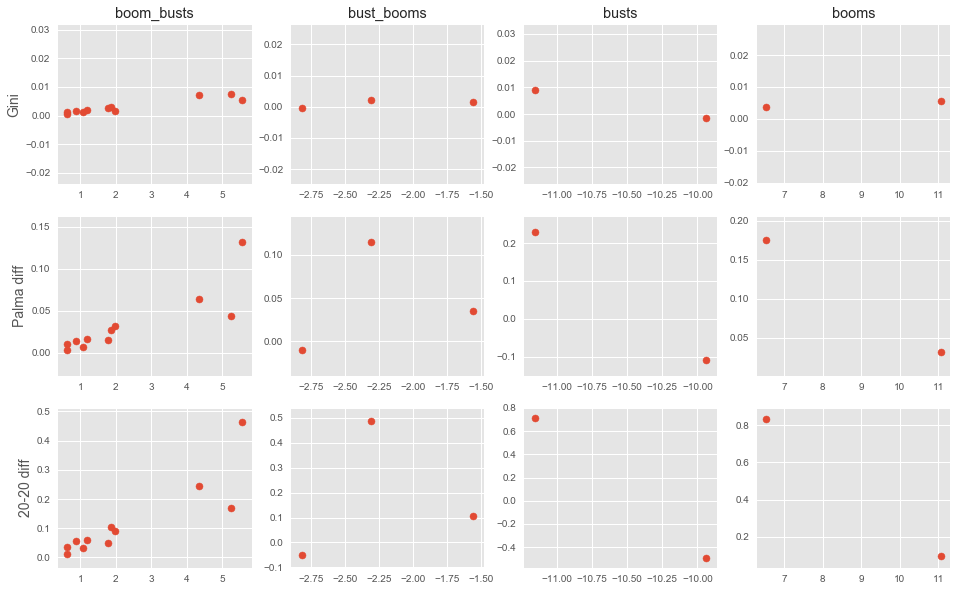

In [38]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12)) = plt.subplots(3, 4, figsize=[16,10])

ax1.scatter(boom_busts['magnitude'], boom_busts['gini_diff'])
ax2.scatter(bust_booms['magnitude'], bust_booms['gini_diff'])
ax3.scatter(busts['magnitude'], busts['gini_diff'])
ax4.scatter(booms['magnitude'], booms['gini_diff'])

ax5.scatter(boom_busts['magnitude'], boom_busts['palma_diff'])
ax6.scatter(bust_booms['magnitude'], bust_booms['palma_diff'])
ax7.scatter(busts['magnitude'], busts['palma_diff'])
ax8.scatter(booms['magnitude'], booms['palma_diff'])

ax9.scatter(boom_busts['magnitude'], boom_busts['twtw_diff'])
ax10.scatter(bust_booms['magnitude'], bust_booms['twtw_diff'])
ax11.scatter(busts['magnitude'], busts['twtw_diff'])
ax12.scatter(booms['magnitude'], booms['twtw_diff'])

ax1.set_title('boom_busts')
ax2.set_title('bust_booms')
ax3.set_title('busts')
ax4.set_title('booms')

ax1.set_ylabel('Gini', fontsize=14)
ax5.set_ylabel('Palma diff', fontsize=14)
ax9.set_ylabel('20-20 diff', fontsize=14)

### Gini regression

In [43]:
gini_reg1 = sm.OLS(endog=boom_busts['gini_diff'], exog=boom_busts[['const', 'lenght', 'magnitude']], missing='drop')
gini_reg2 = sm.OLS(endog=bust_booms['gini_diff'], exog=bust_booms[['const', 'lenght', 'magnitude']], missing='drop')
gini_reg3 = sm.OLS(endog=busts['gini_diff'], exog=busts[['const', 'lenght', 'magnitude']], missing='drop')
gini_reg4 = sm.OLS(endog=booms['gini_diff'], exog=booms[['const', 'lenght', 'magnitude']], missing='drop')

gini_res1 = gini_reg1.fit()
gini_res2 = gini_reg2.fit()
gini_res3 = gini_reg3.fit()
gini_res4 = gini_reg4.fit()

In [60]:
info_dict={'R-squared' : lambda x: "{}".format(x.rsquared), 
           'No. observations' : lambda x: "{}".format(int(x.nobs))}

results_table = summary_col(results=[gini_res1,gini_res2,gini_res3, gini_res4],
                            float_format='%0.4f',
                            stars = True,
                            model_names=['boom-bust',
                                         'bust-boom',
                                         'busts', 'booms'],
                            info_dict=info_dict,
                            regressor_order=['const', 'lenght', 'magnitude'])

results_table.add_title('Table 2 - OLS Regressions')

print(results_table)

                Table 2 - OLS Regressions
                   boom-bust    bust-boom  busts  booms 
--------------------------------------------------------
const            -0.0001        0.0041    0.0001  0.0000
                 (0.0005)       (inf)     (inf)   (inf) 
lenght           0.0000         0.0001    -0.0002 0.0000
                 (0.0000)       (inf)     (inf)   (inf) 
magnitude        0.0011***      0.0039    -0.0017 0.0005
                 (0.0002)       (inf)     (inf)   (inf) 
No. observations 11             3         2       2     
R-squared        0.898849747932 1.0       1.0     1.0   
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


### Palma regression

In [61]:
palma_reg1 = sm.OLS(endog=boom_busts['palma_diff'], exog=boom_busts[['const', 'lenght', 'magnitude']], missing='drop').fit()
palma_reg2 = sm.OLS(endog=bust_booms['palma_diff'], exog=bust_booms[['const', 'lenght', 'magnitude']], missing='drop').fit()
palma_reg3 = sm.OLS(endog=busts['palma_diff'], exog=busts[['const', 'lenght', 'magnitude']], missing='drop').fit()
palma_reg4 = sm.OLS(endog=booms['palma_diff'], exog=booms[['const', 'lenght', 'magnitude']], missing='drop').fit()

In [63]:
info_dict={'R-squared' : lambda x: "{}".format(x.rsquared), 
           'No. observations' : lambda x: "{}".format(int(x.nobs))}

results_table = summary_col(results=[palma_reg1,palma_reg2,palma_reg3, palma_reg4],
                            float_format='%0.4f',
                            stars = True,
                            model_names=['boom-bust',
                                         'bust-boom',
                                         'busts', 'booms'],
                            info_dict=info_dict,
                            regressor_order=['const', 'lenght', 'magnitude'])

results_table.add_title('Table 2 - OLS Regressions')

print(results_table)

                Table 2 - OLS Regressions
                   boom-bust    bust-boom  busts  booms 
--------------------------------------------------------
const            0.0071         0.0736    0.0040  0.0001
                 (0.0082)       (inf)     (inf)   (inf) 
lenght           -0.0005**      0.0042    -0.0077 0.0004
                 (0.0002)       (inf)     (inf)   (inf) 
magnitude        0.0252***      0.1549    -0.0508 0.0014
                 (0.0035)       (inf)     (inf)   (inf) 
No. observations 11             3         2       2     
R-squared        0.883575751244 1.0       1.0     1.0   
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


## 20-20 regression

In [62]:
twtw_reg1 = sm.OLS(endog=boom_busts['twtw_diff'], exog=boom_busts[['const', 'lenght', 'magnitude']], missing='drop').fit()
twtw_reg2 = sm.OLS(endog=bust_booms['twtw_diff'], exog=bust_booms[['const', 'lenght', 'magnitude']], missing='drop').fit()
twtw_reg3 = sm.OLS(endog=busts['twtw_diff'], exog=busts[['const', 'lenght', 'magnitude']], missing='drop').fit()
twtw_reg4 = sm.OLS(endog=booms['twtw_diff'], exog=booms[['const', 'lenght', 'magnitude']], missing='drop').fit()

In [64]:
info_dict={'R-squared' : lambda x: "{}".format(x.rsquared), 
           'No. observations' : lambda x: "{}".format(int(x.nobs))}

results_table = summary_col(results=[twtw_reg1,twtw_reg2,twtw_reg3, twtw_reg4],
                            float_format='%0.4f',
                            stars = True,
                            model_names=['boom-bust',
                                         'bust-boom',
                                         'busts', 'booms'],
                            info_dict=info_dict,
                            regressor_order=['const', 'lenght', 'magnitude'])

results_table.add_title('Table 2 - OLS Regressions')

print(results_table)

               Table 2 - OLS Regressions
                   boom-bust   bust-boom  busts  booms 
-------------------------------------------------------
const            0.0227        0.2181    0.0136  0.0001
                 (0.0267)      (inf)     (inf)   (inf) 
lenght           -0.0019**     0.0186    -0.0278 0.0018
                 (0.0006)      (inf)     (inf)   (inf) 
magnitude        0.0897***     0.6554    -0.1725 0.0009
                 (0.0113)      (inf)     (inf)   (inf) 
No. observations 11            3         2       2     
R-squared        0.90324842569 1.0       1.0     1.0   
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
